**Dénes Csala**  
University of Bristol, 2022  

Based on *Elements of Data Science* ([Allen B. Downey](https://allendowney.com), 2021) and *Python Data Science Handbook* ([Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/), 2018)

License: [MIT](https://mit-license.org/)

# Time-series: Hiearchical clustering

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

## Loading financial data into _pandas_

Install _Yahoo Finance_. If you put a `!` in the first character of a cell, it becomes a _Linux_ command. The cell below would install the `yfinance` _python package_, using the `pip` package manager tool. However, when you run the cell for the second time (in _Colab_ the packages you install persist for about 8 hours) it is already installed - so you get only `Requirement already satisfied` messages.

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf

In [ ]:
nvda = yf.Ticker("NVDA").history(period='5y')
tsla = yf.Ticker("TSLA").history(period='5y')
ryaay = yf.Ticker("RYAAY").history(period='5y')
wizz = yf.Ticker("WIZZ.L").history(period='5y')
rr = yf.Ticker("RR.L").history(period='5y')
btc = yf.Ticker("BTC-USD").history(period='5y')
ab = yf.Ticker("EADSY").history(period='5y')

Now we have downloaded the data for four stocks, computer graphics company nVidia `NVDA` and electric vehicle manufacturer Tesla `TSLA`, and low-cost airlines RyanAir `RYAAY` and WizzAir `WIZZ.L` for the past 5 years.

The responses returned are _pandas_ `DataFrames`. They contain [OHLC](https://www.investopedia.com/terms/o/ohlcchart.asp) data, but we only need the `Close` columns this time. Let us also give them names.

In [ ]:
nvda=nvda[['Close']]
nvda['Name']='NVDA'

In [ ]:
nvda.head()

,Close,Name
Date,,
2017-11-27 00:00:00-05:00,53.008415,NVDA
2017-11-28 00:00:00-05:00,52.159348,NVDA
2017-11-29 00:00:00-05:00,48.621994,NVDA
2017-11-30 00:00:00-05:00,49.683945,NVDA
2017-12-01 00:00:00-05:00,48.933887,NVDA


This is what we want. However surely, there is a more efficient way to automating this, if we have multiple stocks.

In [ ]:
dfs=[] #create empty list of dataframes
for x in ['NVDA','TSLA','RYAAY','WIZZ.L','RR.L','BTC-USD','EADSY']:
  df = yf.Ticker(x).history(period='5y')
  df=df[['Close']]
  df['Name']=x
  dfs.append(df) #append newly download and formatted dataframe to our list of dtaaframes

Great. Now we have a list of `DataFrame`s, each containing the closing stock price and the stock name, for the past 5 years. 

In [ ]:
dfs[2]

,Close,Name
Date,,
2017-11-27 00:00:00-05:00,120.400002,RYAAY
2017-11-28 00:00:00-05:00,122.199997,RYAAY
2017-11-29 00:00:00-05:00,126.690002,RYAAY
2017-11-30 00:00:00-05:00,121.940002,RYAAY
2017-12-01 00:00:00-05:00,120.449997,RYAAY
...,...,...
2022-11-18 00:00:00-05:00,73.980003,RYAAY
2022-11-21 00:00:00-05:00,74.989998,RYAAY
2022-11-22 00:00:00-05:00,75.949997,RYAAY


### Concatenation

We can combine `DataFrames` by stacking them on top of each other using `concat`. They must have the same `column` names (otherwise, empty columns will be created and filled with `NaN`s). The `pd.concat` function accepts only `list []` arguments - therefore, the `DataFrame`s to be combined have to be in the format `[dfA, dfB]`.

In [ ]:
pd.concat(dfs)

,Close,Name
Date,,
2017-11-27 00:00:00-05:00,53.008423,NVDA
2017-11-28 00:00:00-05:00,52.159355,NVDA
2017-11-29 00:00:00-05:00,48.622002,NVDA
2017-11-30 00:00:00-05:00,49.683945,NVDA
2017-12-01 00:00:00-05:00,48.933899,NVDA
...,...,...
2022-11-18 00:00:00-05:00,29.570000,EADSY
2022-11-21 00:00:00-05:00,29.230000,EADSY
2022-11-22 00:00:00-05:00,29.400000,EADSY


### Joining

Sometimes, the dataframes to be joined need to end up next to each other, a "_horizontal_ `concat`". This is called `join`. The `DataFrames` to be combined must have the same index. They must _not_ have any matching `column` names - though these can be renamed automatically using `lsuffix` or `rsuffix`.

In [ ]:
ryan=dfs[2]
wizz=dfs[3]
nvda=dfs[0]
nvda.index=nvda.index.astype(str).str[:10]
wizz.index=wizz.index.astype(str).str[:10]
ryan.index=ryan.index.astype(str).str[:10]
ryan.join(wizz,rsuffix='_right').join(nvda,rsuffix='_nn')

,Close,Name,Close_right,Name_right,Close_nn,Name_nn
Date,,,,,,
2017-11-27,120.400002,RYAAY,NaN,NaN,53.008423,NVDA
2017-11-28,122.199997,RYAAY,3320.0,WIZZ.L,52.159355,NVDA
2017-11-29,126.690002,RYAAY,3340.0,WIZZ.L,48.622002,NVDA
2017-11-30,121.940002,RYAAY,3344.0,WIZZ.L,49.683945,NVDA
2017-12-01,120.449997,RYAAY,3456.0,WIZZ.L,48.933899,NVDA
...,...,...,...,...,...,...
2022-11-18,73.980003,RYAAY,2210.0,WIZZ.L,154.089996,NVDA
2022-11-21,74.989998,RYAAY,2225.0,WIZZ.L,153.169998,NVDA
2022-11-22,75.949997,RYAAY,2012.0,WIZZ.L,160.380005,NVDA


Let's do something smarter:

In [ ]:
dfz=pd.DataFrame() #initialise empty DataFrame
for x in dfs:
  stock_name=x['Name'].values[0]
  stock_name=stock_name.replace('.','')
  x=x[['Close']]
  x.index=x.index.astype(str).str[:10]
  x.columns=[stock_name]
  dfz=x.join(dfz)

In [ ]:
dfz.to_csv('my_stocks.csv')

In [ ]:
dfz

,EADSY,BTC-USD,RRL,WIZZL,RYAAY,TSLA,NVDA
Date,,,,,,,
2017-11-27,23.907942,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-28,24.114204,10058.799805,271.089264,3320.0,122.199997,21.170000,52.159355
2017-11-29,24.282969,9888.610352,268.284882,3340.0,126.690002,20.502666,48.622002
2017-11-30,24.301722,10233.599609,267.038483,3344.0,121.940002,20.590000,49.683945
2017-12-01,23.907942,10975.599609,261.118134,3456.0,120.449997,20.435333,48.933899
...,...,...,...,...,...,...,...
2022-11-18,29.570000,16697.777344,85.489998,2210.0,73.980003,180.190002,154.089996
2022-11-21,29.230000,15787.284180,84.809998,2225.0,74.989998,167.869995,153.169998
2022-11-22,29.400000,16189.769531,85.290001,2012.0,75.949997,169.910004,160.380005


## Clustering of time-series data

In [ ]:
import scipy.cluster.hierarchy as sch

In [ ]:
stocks=pd.read_csv('my_stocks.csv').dropna()
for x in stocks.columns[1:8]:
  stocks[x+'_z_norm']= (stocks[x] - stocks[x].mean())/stocks[x].std()
stock_stack=stocks.set_index('Date').stack().reset_index()
stock_stack.columns=['Date','Stock','Value']
stock_stack['Date']=pd.to_datetime(stock_stack['Date'])
stock_stack=stock_stack[stock_stack['Stock'].str.contains('z_norm')]
stock_stack.head()

,Date,Stock,Value
7,2017-11-28,EADSY_z_norm,-0.726707
8,2017-11-28,BTC-USD_z_norm,-0.599436
9,2017-11-28,RRL_z_norm,1.090609
10,2017-11-28,WIZZL_z_norm,-0.246525
11,2017-11-28,RYAAY_z_norm,1.586387


In [ ]:
timeSeries=stock_stack.set_index(['Date','Stock']).unstack()['Value']
timeSeries.columns=[i[:4] for i in timeSeries.columns]

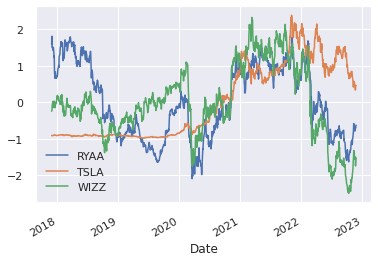

In [ ]:
timeSeries[list(timeSeries.columns)[4:]].plot()

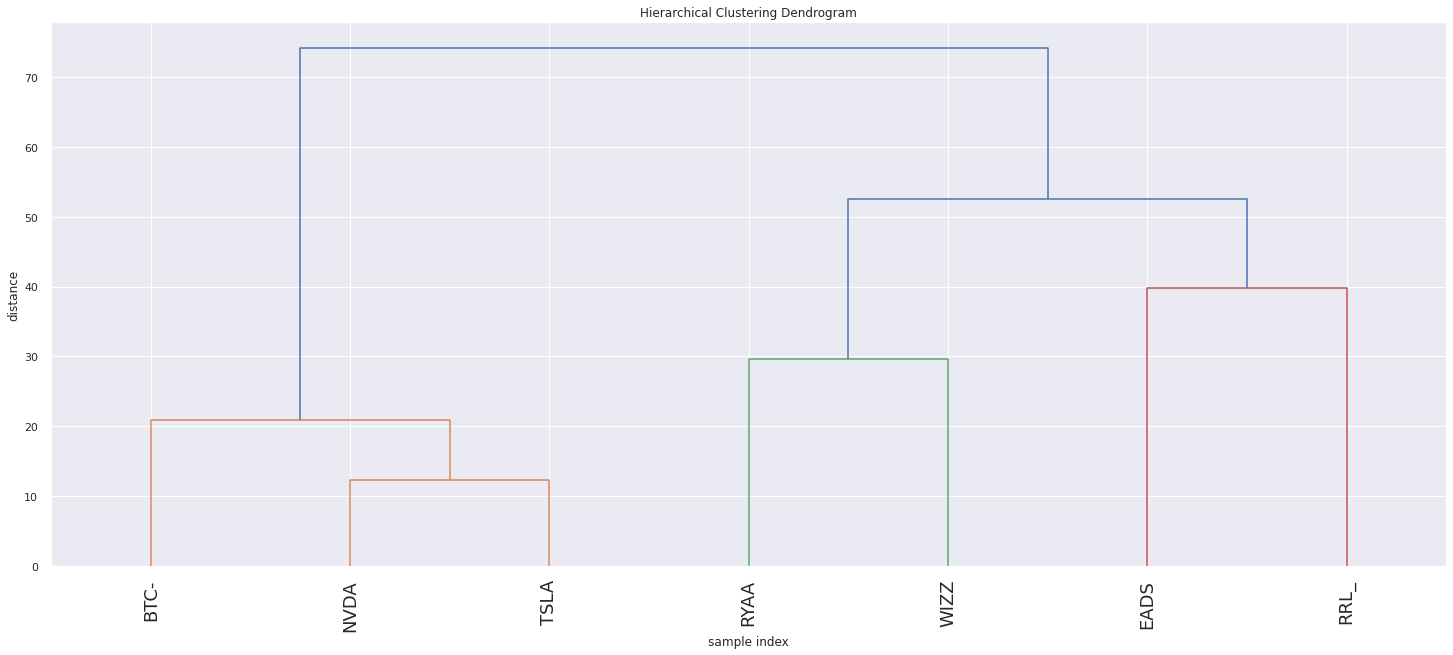

In [ ]:
Z = sch.linkage(timeSeries.T, method='ward', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sch.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=18.,  # font size for the x axis labels
    labels=timeSeries.columns
)
plt.show()

### Dynamic Time Warping

In [ ]:
import numpy as np

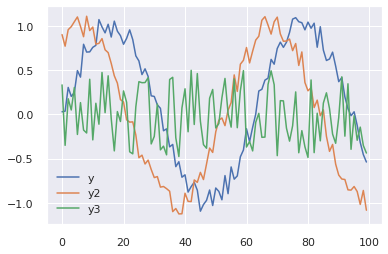

In [ ]:
x=[i/10.0 for i in range(100)]
y=[np.sin(i)+(np.random.uniform()-0.5)*0.3 for i in x]
y2=[np.sin(i+1)+(np.random.uniform()-0.5)*0.3 for i in x]
y3=[np.random.uniform()-0.5 for i in x]
df=pd.DataFrame([y,y2,y3],index=['y','y2','y3']).T
df.plot()

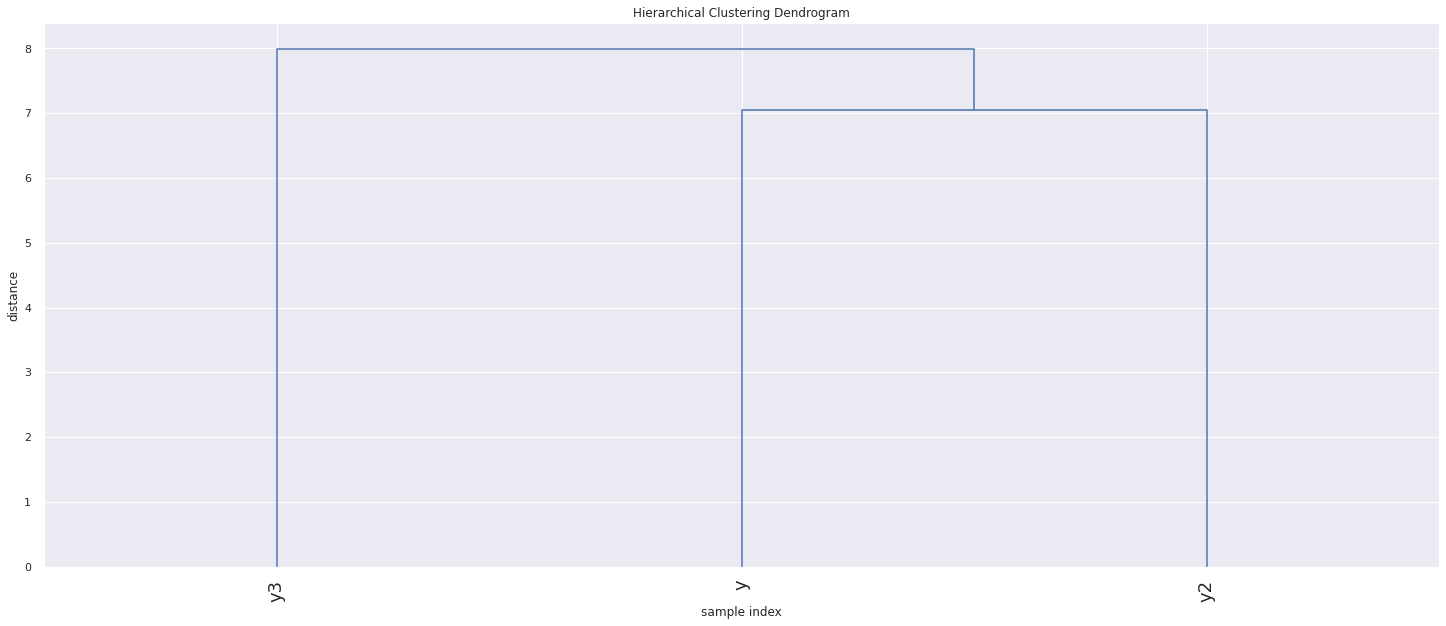

In [ ]:
Z = sch.linkage(df.T, method='ward', metric='euclidean')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sch.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=18.,  # font size for the x axis labels
    labels=df.columns
)
plt.show()

In [ ]:
!pip install dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.4 MB/s 


In [ ]:
from dtaidistance import dtw

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f95d0389650>,
       dtype=object))

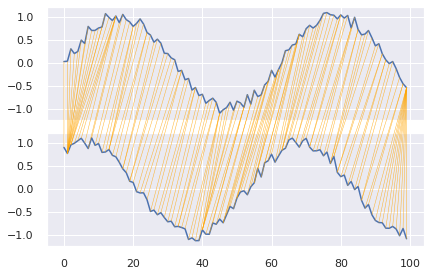

In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np
path = dtw.warping_path(y, y2)
dtwvis.plot_warping(y, y2, path)

In [ ]:
from dtaidistance import clustering
model = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model.fit(np.array(df.T))

(None, array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f95d00de490>,
       dtype=object))

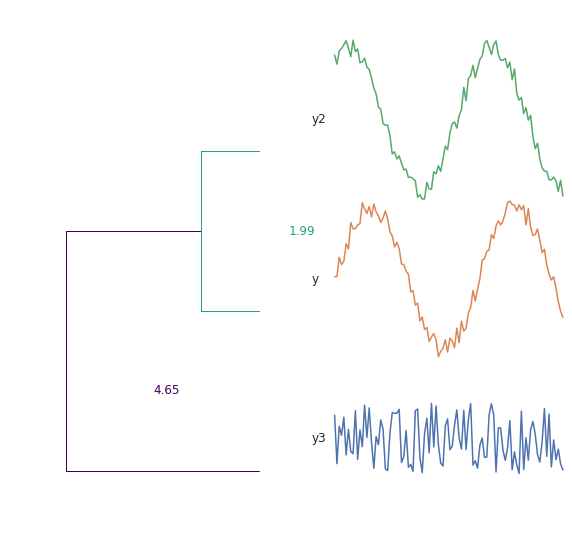

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
model.plot(axes=ax, show_ts_label=df.columns,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)

In [ ]:
cluster_idx = model.fit(np.array(timeSeries.T))

(None, array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f95d010d810>,
       dtype=object))

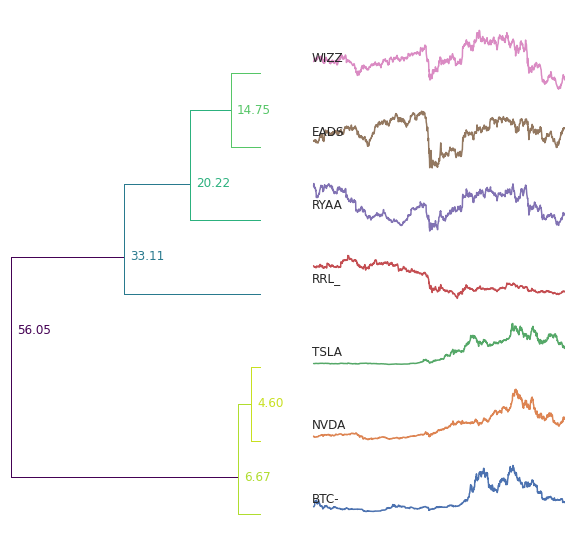

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
model.plot(axes=ax, show_ts_label=timeSeries.columns,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)

### Hierarchical clustering on IRIS dataset

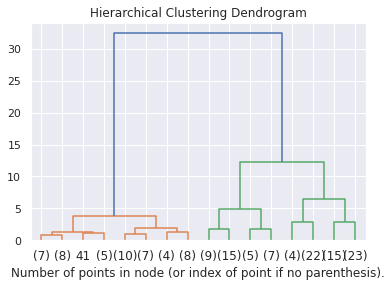

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()